In [1]:
%%writefile blackjack_env.py
import numpy as np
import random
from collections import defaultdict
from enum import Enum

# Define actions available to the player
class Action(Enum):
    STAND = 0
    HIT = 1
    DOUBLE = 2
    SPLIT = 3
    SURRENDER = 4  # New action: Player can surrender their hand

class BlackjackEnv:
    """
    A simplified Blackjack environment for reinforcement learning.
    Supports various rule variations.
    """
    def __init__(self, decks=6, penetration=0.5, rules=None):
        """
        Initializes the Blackjack environment.

        Args:
            decks (int): Number of decks in the shoe.
            penetration (float): Proportion of the shoe to be played before reshuffling.
            rules (set): A set of strings representing enabled rule variations (e.g., {'double_allowed', 'late_surrender'}).
        """
        self.decks = decks
        self.penetration = penetration
        self.rules = rules if rules else set()  # Store rules as a set for easy lookup
        self.action_space = len(Action)  # Total number of possible actions
        self.gamma = 0.95  # Discount factor (though often 1.0 for episodic tasks like Blackjack)
        self.action_meanings = ["STAND", "HIT", "DOUBLE", "SPLIT", "SURRENDER"]
        self.initial_num_decks = decks
        self.cards_drawn_this_episode = 0
        self.done = False  # Flag to indicate if the episode is finished
        self.deck = []  # The current shoe of cards
        self.cut_card = 0  # Index where reshuffling occurs

    def reset(self):
        """
        Resets the environment for a new episode (hand).
        Creates a new shoe, deals initial cards, and resets episode state.

        Returns:
            tuple: The initial state of the environment (player_value, dealer_up_card_value, usable_ace).
        """
        self.player_hand = []
        self.dealer_hand = []
        self.deck = self._create_shoe()  # Create and shuffle a new shoe
        self.done = False
        self.cards_drawn_this_episode = 0
        self._deal_initial_cards()  # Deal two cards to player and dealer
        return self._get_state()

    def _create_shoe(self):
        """
        Creates a new shoe (deck(s) of cards) and shuffles it.
        Sets the cut card position based on penetration.

        Returns:
            list: A list representing the shuffled shoe.
        """
        ranks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4  # 10 for J, Q, K; 11 for Ace
        shoe = ranks * self.decks
        random.shuffle(shoe)
        # Cut card ensures a certain percentage of cards are played before reshuffling
        self.cut_card = max(1, int(len(shoe) * self.penetration))
        return shoe

    def _draw_card(self):
        """
        Draws a single card from the shoe. If the cut card is reached, reshuffles.

        Returns:
            int: The value of the drawn card. Returns 0 if deck is empty (should not happen with proper logic).
        """
        self.cards_drawn_this_episode += 1
        if len(self.deck) <= self.cut_card:
            # Reshuffle if penetration reached.
            # For counting env, running_count reset happens in its _draw_card override.
            self.deck = self._create_shoe()

        if not self.deck:
            # Fallback for an empty deck, though ideally, this condition is avoided.
            return 0

        card = self.deck.pop()
        return card

    def _deal_initial_cards(self):
        """Deals two cards to the player and two to the dealer."""
        self.player_hand = [self._draw_card(), self._draw_card()]
        self.dealer_hand = [self._draw_card(), self._draw_card()]

    def _hand_value(self, hand):
        """
        Calculates the value of a given hand, handling Aces (1 or 11).

        Args:
            hand (list): A list of card values in the hand.

        Returns:
            int: The calculated total value of the hand.
        """
        total = sum(hand)
        aces = hand.count(11)

        # Convert Ace from 11 to 1 if busting (total > 21)
        while total > 21 and aces:
            total -= 10
            aces -= 1
        return total

    def _resolve_hand(self):
        """
        Resolves the outcome of the hand after the player stands or busts.
        Dealer plays their hand according to standard rules (hit until 17+).

        Returns:
            int: Reward for the hand (1 for win, 0 for push, -1 for loss).
        """
        player_val = self._hand_value(self.player_hand)
        dealer_val = self._hand_value(self.dealer_hand)

        # NEW Rule: Player 21 always wins (even against dealer's 21)
        if 'player_21_always_wins' in self.rules and player_val == 21:
            return 1  # Player wins if they have 21, regardless of dealer's hand

        if player_val > 21:
            return -1  # Player busts, loses

        # Dealer hits until their hand value is 17 or more
        while dealer_val < 17:
            self.dealer_hand.append(self._draw_card())
            dealer_val = self._hand_value(self.dealer_hand)

        if dealer_val > 21:
            return 1  # Dealer busts, player wins
        elif player_val > dealer_val:
            return 1  # Player has higher value, player wins
        elif player_val < dealer_val:
            return -1  # Dealer has higher value, player loses
        return 0  # It's a push (tie)

    def _get_state(self):
        """
        Returns the current state of the environment from the player's perspective.

        Returns:
            tuple: (player_hand_value, dealer_up_card_value, usable_ace_indicator).
        """
        player_val = self._hand_value(self.player_hand)
        dealer_val = self._hand_value([self.dealer_hand[0]])  # Only dealer's up-card is visible
        usable_ace = 1 if 11 in self.player_hand and player_val <= 21 else 0  # 1 if player has a soft hand, 0 otherwise
        return (player_val, dealer_val, usable_ace)

    def step(self, action):
        """
        Processes a single action taken by the player.

        Args:
            action (int): The action chosen by the agent (from Action Enum).

        Returns:
            tuple: (next_state, reward, done, info_dict).
                next_state (tuple): The new state after the action.
                reward (float): The immediate reward received.
                done (bool): True if the episode has ended, False otherwise.
                info_dict (dict): Additional information (e.g., original action taken).
        """
        if self.done:
            # If the episode is already done, no further actions are allowed.
            return self._get_state(), 0, True, {}

        reward = 0
        current_done_state = False
        original_action = action  # Store the action requested by the agent

        # Check if the dealer has a natural blackjack (used for late surrender rule)
        # This is a simplified check; in real casinos, dealer peeks for BJ only on 10/Ace up-card.
        # Here, we check the full initial dealer hand.
        dealer_has_natural_blackjack = (len(self.dealer_hand) == 2 and self._hand_value(self.dealer_hand) == 21)

        # Handle SURRENDER action
        if action == Action.SURRENDER.value:
            # Late surrender rule: allowed only on initial two cards and if dealer does NOT have natural BJ
            if 'late_surrender' in self.rules and len(self.player_hand) == 2:
                if not dealer_has_natural_blackjack:
                    reward = -0.5  # Player gets half their bet back
                    current_done_state = True
                else:
                    # Dealer has natural blackjack, surrender is invalid.
                    # The agent's surrender action is ignored, and they must play on.
                    # We'll treat this as if they chose to STAND as a default invalid action.
                    action = Action.STAND.value
            else:
                # Surrender not allowed (e.g., rule not enabled, or not initial hand).
                # Treat as STAND as a fallback for an invalid action.
                action = Action.STAND.value

        # Proceed with other actions if the episode is not already done by surrender
        if not current_done_state:
            if action == Action.HIT.value:
                self.player_hand.append(self._draw_card())
                if self._hand_value(self.player_hand) > 21:
                    current_done_state = True
                    reward = -1  # Player busts

            elif action == Action.STAND.value:
                current_done_state = True
                reward = self._resolve_hand()

            elif action == Action.DOUBLE.value and 'double_allowed' in self.rules:
                if len(self.player_hand) == 2:  # Can only double down on initial two cards
                    self.player_hand.append(self._draw_card())
                    current_done_state = True
                    if self._hand_value(self.player_hand) > 21:
                        reward = -2  # Double down and bust (lose twice the bet)
                    else:
                        reward = self._resolve_hand() * 2  # Double down and resolve (win/lose twice)
                else:
                    # Invalid double attempt (not initial hand), treat as STAND
                    action = Action.STAND.value
                    current_done_state = True
                    reward = self._resolve_hand()

            elif action == Action.SPLIT.value and 'splitting_allowed' in self.rules and \
                 len(self.player_hand) == 2 and self.player_hand[0] == self.player_hand[1]:
                # Simplified splitting: For this environment, we'll treat a split action
                # as a STAND. A full splitting implementation would require managing
                # multiple hands and is significantly more complex for this structure.
                action = Action.STAND.value
                current_done_state = True
                reward = self._resolve_hand()
            else:
                # Fallback for any other invalid action or disabled rule: treat as STAND
                action = Action.STAND.value
                current_done_state = True
                reward = self._resolve_hand()

        self.done = current_done_state
        # Return original_action in info for debugging/tracking purposes
        return self._get_state(), reward, self.done, {'action_taken': original_action}

    # Helper method to resolve a single player hand against a given dealer hand
    def _resolve_one_hand(self, player_current_hand_value, dealer_current_hand_list):
        if player_current_hand_value > 21:
            return -1 # Player busts

        local_dealer_hand = list(dealer_current_hand_list) # Work on a copy of dealer's hand for this resolution
        
        # Dealer hits until 17 or more
        while self._hand_value(local_dealer_hand) < 17:
            local_dealer_hand.append(self._draw_card()) # Draws from the shared deck
            
        dealer_val = self._hand_value(local_dealer_hand)

        if dealer_val > 21:
            return 1 # Dealer busts, player wins
        elif player_current_hand_value > dealer_val:
            return 1 # Player has higher value, player wins
        elif player_current_hand_value < dealer_val:
            return -1 # Dealer has higher value, player loses
        return 0 # It's a push (tie)


class BlackjackWithCountingEnv(BlackjackEnv):
    """
    Extends BlackjackEnv to include card counting functionality.
    The state space is augmented with a 'true count' bin.
    """
    def __init__(self, decks=6, penetration=0.5, rules=None):
        super().__init__(decks, penetration, rules)
        self.card_values = self._create_count_system()  # Defines card values for counting
        self.running_count = 0  # The current running count
        self.min_bet = 1  # Minimum bet for betting strategy
        self.max_bet = 10  # Maximum bet for betting strategy
        self.initial_deck_size = 52 * self.decks

    def _create_count_system(self):
        """
        Defines the High-Low card counting system values.
        """
        return {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 11: -1}

    def _draw_card(self):
        """
        Overrides the base _draw_card to update the running count.
        Resets running count when a new shoe is created.
        """
        self.cards_drawn_this_episode += 1
        if len(self.deck) <= self.cut_card:
            self.deck = self._create_shoe()
            self.running_count = 0  # Reset count when a new shoe is introduced

        if not self.deck:
            return 0

        card = self.deck.pop()
        self.running_count += self.card_values.get(card, 0)  # Update running count
        return card

    def reset(self):
        """
        Resets the environment and the running count for a new hand.
        """
        self.running_count = 0  # Reset running count at the start of each new hand/episode
        return super().reset()

    def _get_state(self):
        """
        Overrides the base _get_state to include the binned true count.

        Returns:
            tuple: (player_value, dealer_up_card_value, usable_ace_indicator, true_count_bin).
        """
        base_state = super()._get_state()

        deck_remaining_cards = len(self.deck)
        # Calculate effective decks remaining, with a minimum to prevent division by zero
        effective_decks_remaining = deck_remaining_cards / 52.0
        if effective_decks_remaining < 0.1:
            effective_decks_remaining = 0.1

        true_count = self.running_count / effective_decks_remaining

        # Bin the true count into discrete categories for state representation
        if true_count < -3:
            count_bin = -2
        elif true_count < -1:
            count_bin = -1
        elif true_count < 1:
            count_bin = 0
        elif true_count < 3:
            count_bin = 1
        else:
            count_bin = 2

        return (*base_state, count_bin)

    def step(self, action):
        """
        Processes a single action taken by the player, applying betting strategy.

        Args:
            action (int): The action chosen by the agent (from Action Enum).

        Returns:
            tuple: (next_state, reward, done, info_dict).
                next_state (tuple): The new state after the action.
                reward (float): The immediate reward received.
                done (bool): True if the episode has ended, False otherwise.
                info_dict (dict): Additional information (e.g., original action taken).
        """
        if self.done:
            return self._get_state(), 0, True, {}

        reward = 0
        current_done_state = False
        original_action = action

        dealer_has_natural_blackjack = (len(self.dealer_hand) == 2 and self._hand_value(self.dealer_hand) == 21)

        if action == Action.SURRENDER.value:
            if 'late_surrender' in self.rules and len(self.player_hand) == 2:
                if not dealer_has_natural_blackjack:
                    reward = -0.5
                    current_done_state = True
                else:
                    action = Action.STAND.value # Treat as STAND if surrender is invalid
            else:
                action = Action.STAND.value # Treat as STAND if surrender not allowed by rules/hand

        if not current_done_state:
            if action == Action.HIT.value:
                self.player_hand.append(self._draw_card())
                if self._hand_value(self.player_hand) > 21:
                    current_done_state = True
                    reward = -1

            elif action == Action.STAND.value:
                current_done_state = True
                reward = self._resolve_hand()

            elif action == Action.DOUBLE.value and 'double_allowed' in self.rules:
                if len(self.player_hand) == 2:
                    self.player_hand.append(self._draw_card())
                    current_done_state = True
                    if self._hand_value(self.player_hand) > 21:
                        reward = -2
                    else:
                        reward = self._resolve_hand() * 2
                else:
                    # Invalid double attempt (not initial hand), treat as STAND
                    action = Action.STAND.value
                    current_done_state = True
                    reward = self._resolve_hand()

            elif action == Action.SPLIT.value and 'splitting_allowed' in self.rules and \
                 len(self.player_hand) == 2 and self.player_hand[0] == self.player_hand[1]:
                
                card_to_split = self.player_hand[0]
                total_split_reward = 0
                original_dealer_hand_at_split = list(self.dealer_hand) # Capture dealer's initial hand for both resolutions

                # --- Play out First Split Hand ---
                current_player_split_hand_1 = [card_to_split, self._draw_card()]
                # Simplified strategy for split hands: hit until 17 or bust
                while self._hand_value(current_player_split_hand_1) < 17 and self._hand_value(current_player_split_hand_1) <= 21:
                    current_player_split_hand_1.append(self._draw_card())
                
                # Resolve this split hand against the dealer's original hand
                reward1 = self._resolve_one_hand(self._hand_value(current_player_split_hand_1), original_dealer_hand_at_split)
                total_split_reward += reward1

                # --- Play out Second Split Hand ---
                current_player_split_hand_2 = [card_to_split, self._draw_card()]
                # Simplified strategy for split hands: hit until 17 or bust
                while self._hand_value(current_player_split_hand_2) < 17 and self._hand_value(current_player_split_hand_2) <= 21:
                    current_player_split_hand_2.append(self._draw_card())
                
                # Resolve this split hand against the dealer's original hand
                reward2 = self._resolve_one_hand(self._hand_value(current_player_split_hand_2), original_dealer_hand_at_split)
                total_split_reward += reward2
                
                reward = total_split_reward # Sum of rewards from both split hands
                current_done_state = True # Splitting always ends the player's turn for the main hand
                
            else:
                # Fallback for any other invalid action or disabled rule: treat as STAND
                action = Action.STAND.value
                current_done_state = True
                reward = self._resolve_hand()

        self.done = current_done_state

        # Apply betting multiplier if the hand is resolved
        if self.done:
            current_state_tuple_after_action = self._get_state()
            count_bin = current_state_tuple_after_action[3]

            approx_true_count = 0
            if count_bin == -2: approx_true_count = -4
            elif count_bin == -1: approx_true_count = -2
            elif count_bin == 0: approx_true_count = 0
            elif count_bin == 1: approx_true_count = 2
            else: approx_true_count = 4

            bet_multiplier = self.min_bet # Default bet for negative/neutral counts

            # More aggressive betting strategy for positive true counts
            if approx_true_count == 2: # Corresponds to count_bin 1
                bet_multiplier = 4 # Bet 4 units
            elif approx_true_count == 4: # Corresponds to count_bin 2
                bet_multiplier = 8 # Bet 8 units
            
            bet_multiplier = min(self.max_bet, bet_multiplier) # Cap at max_bet
            
            reward *= bet_multiplier # Scale reward by the bet multiplier

        final_state = self._get_state()
        return final_state, reward, self.done, {'action_taken': original_action}

Overwriting blackjack_env.py


In [9]:
import numpy as np
from collections import defaultdict
from blackjack_env import BlackjackEnv, BlackjackWithCountingEnv, Action
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set a random seed for reproducibility
np.random.seed(42)

# --- Algorithm Implementations ---

def monte_carlo_control(env, episodes=100000, epsilon=0.1, gamma=1.0):
    Q = defaultdict(lambda: np.zeros(env.action_space))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    
    # ADDED: Tracking variables
    episode_rewards = []
    action_counts = np.zeros(env.action_space)
    
    for episode_num in tqdm(range(episodes), desc=f"MC Training for {env.__class__.__name__}"):
        state = env.reset()
        episode_data = []
        episode_reward = 0  # Track cumulative reward
        
        while True:
            if np.random.random() < epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(Q[state])
                
            next_state, reward, done, _ = env.step(action)
            
            # ADDED: Track reward and actions
            episode_reward += reward
            action_counts[action] += 1
            
            episode_data.append((state, action, reward))
            
            if done:
                break
            state = next_state
        
        # ADDED: Store episode reward
        episode_rewards.append(episode_reward)
        
        G = 0
        visited_state_actions = set()
        
        for t in reversed(range(len(episode_data))):
            state_t, action_t, reward_t = episode_data[t]
            G = gamma * G + reward_t
            
            if (state_t, action_t) not in visited_state_actions:
                returns_sum[(state_t, action_t)] += G
                returns_count[(state_t, action_t)] += 1
                Q[state_t][action_t] = returns_sum[(state_t, action_t)] / returns_count[(state_t, action_t)]
                visited_state_actions.add((state_t, action_t))

    return Q, episode_rewards, action_counts  # MODIFIED return

def q_learning_control(env, episodes=2000000, alpha=0.05, gamma=0.99, min_epsilon=0.05):
    Q = defaultdict(lambda: np.zeros(env.action_space))
    
    # ADDED: Tracking variables
    episode_rewards = []
    action_counts = np.zeros(env.action_space)
    
    def get_epsilon(episode):
        return max(min_epsilon, 1.0 - (episode / (episodes * 0.8)))

    for episode in tqdm(range(episodes), desc=f"QL Training for {env.__class__.__name__}"):
        state = env.reset()
        epsilon = get_epsilon(episode)
        done = False
        episode_reward = 0  # Track cumulative reward
        
        train_step_count = 0
        max_train_steps = 500

        while not done:
            train_step_count += 1
            if train_step_count > max_train_steps:
                done = True
                break

            effective_epsilon = epsilon
            if isinstance(env, BlackjackWithCountingEnv) and len(state) == 4 and abs(state[3]) >= 1:
                effective_epsilon = min(1.0, epsilon + 0.2)
                
            if np.random.random() < effective_epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(Q[state])
                
            next_state, reward, current_step_done, _ = env.step(action)
            done = current_step_done
            
            # ADDED: Track reward and actions
            episode_reward += reward
            action_counts[action] += 1
            
            max_next_q = np.max(Q[next_state]) if not done else 0
            td_target = reward + gamma * max_next_q
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error
            
            state = next_state
        
        # ADDED: Store episode reward
        episode_rewards.append(episode_reward)
        
    return Q, episode_rewards, action_counts  # MODIFIED return

def double_q_learning(env, episodes=10000000, alpha=0.005, gamma=0.99, min_epsilon=0.1):
    Q1 = defaultdict(lambda: np.zeros(env.action_space))
    Q2 = defaultdict(lambda: np.zeros(env.action_space))
    
    # ADDED: Tracking variables
    episode_rewards = []
    action_counts = np.zeros(env.action_space)
    
    start_epsilon = 1.0
    epsilon_decay_episodes = episodes * 0.98

    for episode in tqdm(range(episodes), desc=f"Double Q-Learning Training for {env.__class__.__name__}"):
        state = env.reset()
        epsilon = max(min_epsilon, start_epsilon - (episode / epsilon_decay_episodes))
        done = False
        episode_reward = 0  # Track cumulative reward
        
        train_step_count = 0
        max_train_steps = 500

        while not done:
            train_step_count += 1
            if train_step_count > max_train_steps:
                done = True
                break

            total_q = Q1[state] + Q2[state]
            
            effective_epsilon = epsilon
            if isinstance(env, BlackjackWithCountingEnv) and len(state) == 4 and abs(state[3]) >= 2:
                effective_epsilon = min(1.0, epsilon + 0.3)
            
            if np.random.random() < effective_epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(total_q)
                
            next_state, reward, current_step_done, _ = env.step(action)
            done = current_step_done
            
            # ADDED: Track reward and actions
            episode_reward += reward
            action_counts[action] += 1
            
            if np.random.rand() < 0.5:
                best_next_action = np.argmax(Q1[next_state])
                next_q_from_other_table = Q2[next_state][best_next_action] if next_state in Q2 else 0
                td_target = reward + gamma * (next_q_from_other_table if not done else 0)
                Q1[state][action] += alpha * (td_target - Q1[state][action])
            else:
                best_next_action = np.argmax(Q2[next_state])
                next_q_from_other_table = Q1[next_state][best_next_action] if next_state in Q1 else 0
                td_target = reward + gamma * (next_q_from_other_table if not done else 0)
                Q2[state][action] += alpha * (td_target - Q2[state][action])
            
            if done:
                break
            state = next_state
        
        # ADDED: Store episode reward
        episode_rewards.append(episode_reward)
    
    Q_final = defaultdict(lambda: np.zeros(env.action_space))
    all_states = set(Q1.keys()) | set(Q2.keys())
    for state in all_states:
        q1_val = Q1.get(state, np.zeros(env.action_space))
        q2_val = Q2.get(state, np.zeros(env.action_space))
        Q_final[state] = 0.5 * q1_val + 0.5 * q2_val
        
    return Q_final, episode_rewards, action_counts  # MODIFIED return

def evaluate_policy(env, Q, trials=500000, allowed_actions_mask=None):
    rewards = []
    wins = 0
    losses = 0
    pushes = 0
    surrenders = 0 
    natural_bjs = 0  # NEW

    if allowed_actions_mask is None:
        allowed_actions_mask = np.ones(env.action_space, dtype=bool)

    for _ in tqdm(range(trials)):
        state = env.reset()
        done = False
        total_reward = 0

        # Check for natural blackjack before taking any action
        is_player_natural_blackjack = (len(env.player_hand) == 2 and env._hand_value(env.player_hand) == 21)
        is_dealer_natural_blackjack = (len(env.dealer_hand) == 2 and env._hand_value(env.dealer_hand) == 21)

        if is_player_natural_blackjack and not is_dealer_natural_blackjack:
            total_reward = 1.5 if not isinstance(env, BlackjackWithCountingEnv) else 1.5 * env.min_bet
            natural_bjs += 1
            rewards.append(total_reward)
            wins += 1
            continue
        elif is_player_natural_blackjack and is_dealer_natural_blackjack:
            total_reward = 0
            rewards.append(total_reward)
            pushes += 1
            continue
        elif is_dealer_natural_blackjack:
            total_reward = -1 if not isinstance(env, BlackjackWithCountingEnv) else -1 * env.min_bet
            rewards.append(total_reward)
            losses += 1
            continue

        # Main loop
        state = tuple(state) if isinstance(state, np.ndarray) else state

        while not done:
            state_tuple = tuple(state) if not isinstance(state, tuple) else state
            
            if state_tuple in Q:
                q_values = Q[state_tuple]
                masked_q_values = np.where(allowed_actions_mask, q_values, -np.inf)
                action = np.argmax(masked_q_values)
            else:
                action = np.argmax(allowed_actions_mask)  # fallback to first allowed action

            next_state, reward, current_step_done, info = env.step(action)

            # Track successful surrender (only when reward == -0.5)
            if action == Action.SURRENDER and reward == -0.5:
                surrenders += 1

            total_reward = reward  # final step reward overwrites previous
            state = next_state
            done = current_step_done
            state = tuple(state) if isinstance(state, np.ndarray) else state

        rewards.append(total_reward)
        if total_reward > 0:
            wins += 1
        elif total_reward < 0:
            losses += 1
        else:
            pushes += 1

    avg_reward = np.mean(rewards)
    win_rate = wins / trials
    loss_rate = losses / trials
    push_rate = pushes / trials
    surrender_rate = surrenders / trials
    bj_rate = natural_bjs / trials

    return {
        'avg_reward': avg_reward,
        'win_rate': win_rate,
        'loss_rate': loss_rate,
        'push_rate': push_rate,
        'surrender_rate': surrender_rate,
        'natural_blackjack_rate': bj_rate
    }


def get_allowed_actions_mask(env):
    mask = np.ones(env.action_space, dtype=bool)
    # If surrender is NOT allowed in the env rules, mask it out
    if 'late_surrender' not in env.rules:
        mask[Action.SURRENDER] = False
    # You can add similar rules here for other actions if needed
    return mask

# --- Section 1: Training Algorithms ---
print("--- Section 1: Training Algorithms ---")

# Environment Initialization
basic_env = BlackjackEnv(rules={'double_allowed', 'splitting_allowed'})
surrender_env = BlackjackEnv(rules={'double_allowed', 'splitting_allowed', 'late_surrender'})
player21_env = BlackjackEnv(rules={'double_allowed', 'splitting_allowed', 'player_21_always_wins'})
counting_env = BlackjackWithCountingEnv(rules={'double_allowed', 'splitting_allowed'})

environments = {
    "Basic": basic_env,
    "Late Surrender": surrender_env,
    "Player 21 Wins": player21_env,
    "Card Counting": counting_env
}

trained_policies = {}
trained_info = {}

# Define episode counts
mc_episodes_std = 100000
mc_episodes_counting = 1000000
ql_dql_episodes_std = 2000000
ql_dql_episodes_counting = 5000000

# --- Training for Basic Strategy ---
print("\n--- Training for Basic Strategy Environment ---")

print("Starting Monte Carlo Control training for Basic...")
q, rewards, actions = monte_carlo_control(basic_env, episodes=mc_episodes_std)
trained_policies["Basic_MC"] = q
trained_info["Basic_MC"] = {"rewards": rewards, "actions": actions}

print("Starting Q-Learning training for Basic...")
q, rewards, actions = q_learning_control(basic_env, episodes=ql_dql_episodes_std)
trained_policies["Basic_QL"] = q
trained_info["Basic_QL"] = {"rewards": rewards, "actions": actions}

print("Starting Double Q-Learning training for Basic (Enhanced Profit)...")
q, rewards, actions = double_q_learning(basic_env, episodes=ql_dql_episodes_std)
trained_policies["Basic_DQL"] = q
trained_info["Basic_DQL"] = {"rewards": rewards, "actions": actions}

# --- Training for Card Counting Strategy ---
print("\n--- Training for Card Counting Environment ---")

print("Starting Monte Carlo Control training for Card Counting...")
q, rewards, actions = monte_carlo_control(counting_env, episodes=mc_episodes_counting)
trained_policies["Card Counting_MC"] = q
trained_info["Card Counting_MC"] = {"rewards": rewards, "actions": actions}

print("Starting Q-Learning training for Card Counting...")
q, rewards, actions = q_learning_control(counting_env, episodes=ql_dql_episodes_counting)
trained_policies["Card Counting_QL"] = q
trained_info["Card Counting_QL"] = {"rewards": rewards, "actions": actions}

print("Starting Double Q-Learning training for Card Counting (Enhanced Profit)...")
q, rewards, actions = double_q_learning(counting_env, episodes=ql_dql_episodes_counting)
trained_policies["Card Counting_DQL"] = q
trained_info["Card Counting_DQL"] = {"rewards": rewards, "actions": actions}

# --- Training for Late Surrender Strategy ---
print("\n--- Training for Late Surrender Environment ---")

print("Starting Monte Carlo Control training for Late Surrender...")
q, rewards, actions = monte_carlo_control(surrender_env, episodes=mc_episodes_std)
trained_policies["Late Surrender_MC"] = q
trained_info["Late Surrender_MC"] = {"rewards": rewards, "actions": actions}

# --- Training for Player 21 Always Wins Strategy ---
print("\n--- Training for Player 21 Wins Environment ---")

print("Starting Monte Carlo Control training for Player 21 Wins...")
q, rewards, actions = monte_carlo_control(player21_env, episodes=mc_episodes_std)
trained_policies["Player 21 Wins_MC"] = q
trained_info["Player 21 Wins_MC"] = {"rewards": rewards, "actions": actions}

print("\n--- All training complete. ---")

--- Section 1: Training Algorithms ---

--- Training for Basic Strategy Environment ---
Starting Monte Carlo Control training for Basic...


MC Training for BlackjackEnv: 100%|██| 100000/100000 [00:05<00:00, 18025.26it/s]


Starting Q-Learning training for Basic...


QL Training for BlackjackEnv: 100%|█| 2000000/2000000 [01:52<00:00, 17726.62it/s


Starting Double Q-Learning training for Basic (Enhanced Profit)...


Double Q-Learning Training for BlackjackEnv: 100%|█| 2000000/2000000 [01:56<00:0



--- Training for Card Counting Environment ---
Starting Monte Carlo Control training for Card Counting...


MC Training for BlackjackWithCountingEnv: 100%|█| 1000000/1000000 [00:57<00:00, 


Starting Q-Learning training for Card Counting...


QL Training for BlackjackWithCountingEnv: 100%|█| 5000000/5000000 [04:52<00:00, 


Starting Double Q-Learning training for Card Counting (Enhanced Profit)...


Double Q-Learning Training for BlackjackWithCountingEnv: 100%|█| 5000000/5000000



--- Training for Late Surrender Environment ---
Starting Monte Carlo Control training for Late Surrender...


MC Training for BlackjackEnv: 100%|██| 100000/100000 [00:05<00:00, 18280.13it/s]



--- Training for Player 21 Wins Environment ---
Starting Monte Carlo Control training for Player 21 Wins...


MC Training for BlackjackEnv: 100%|██| 100000/100000 [00:05<00:00, 17797.34it/s]


--- All training complete. ---



### BASIC STRATEGY HEATMAPS ###


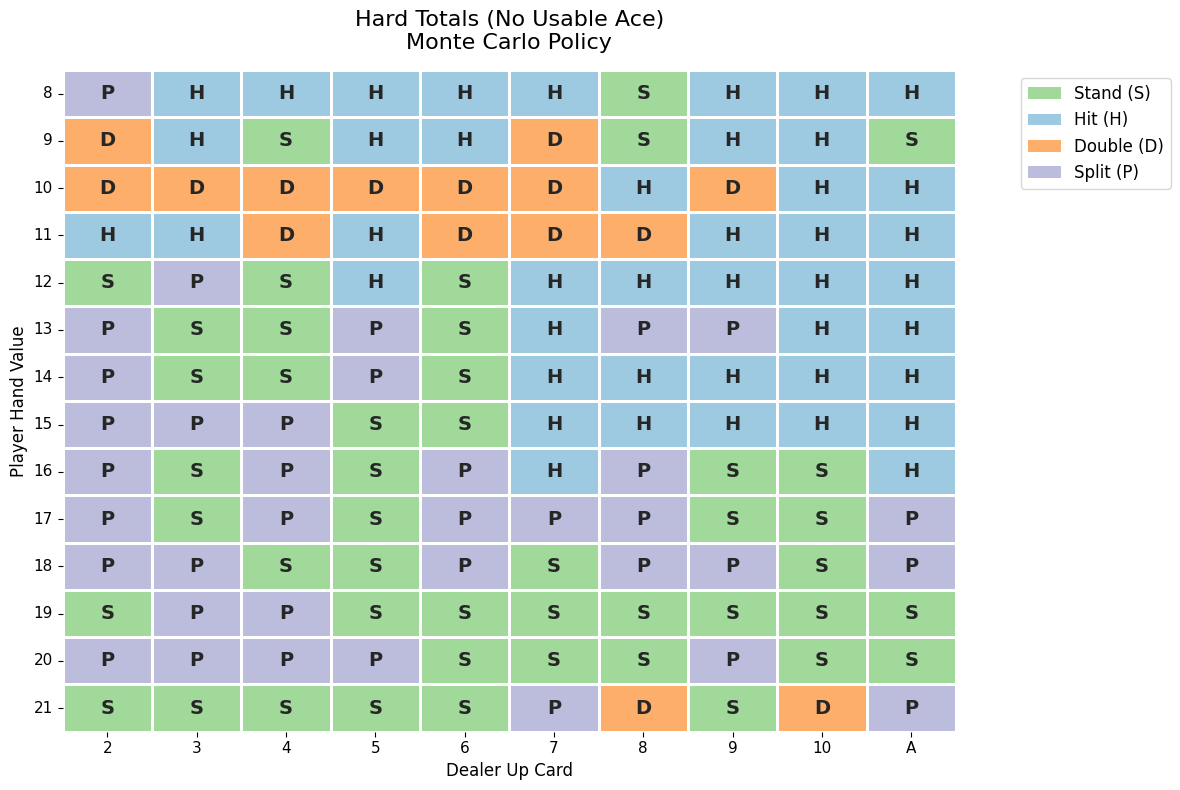

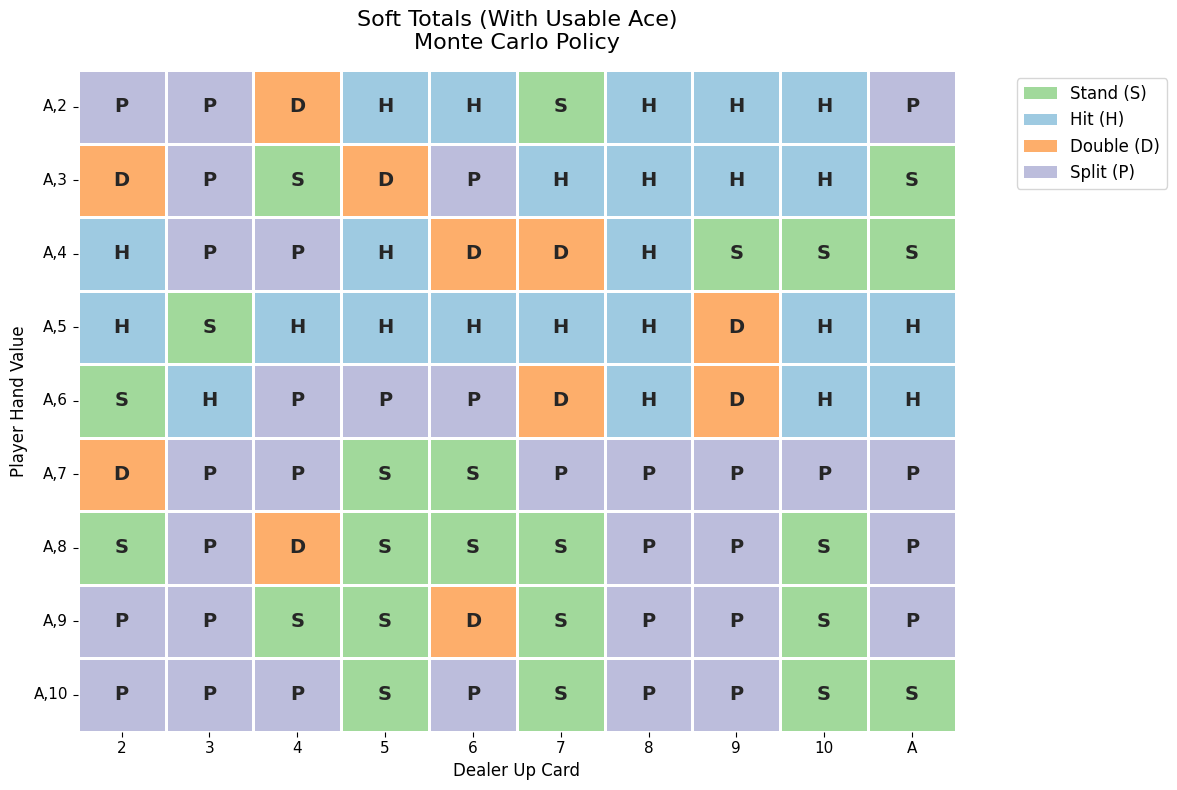

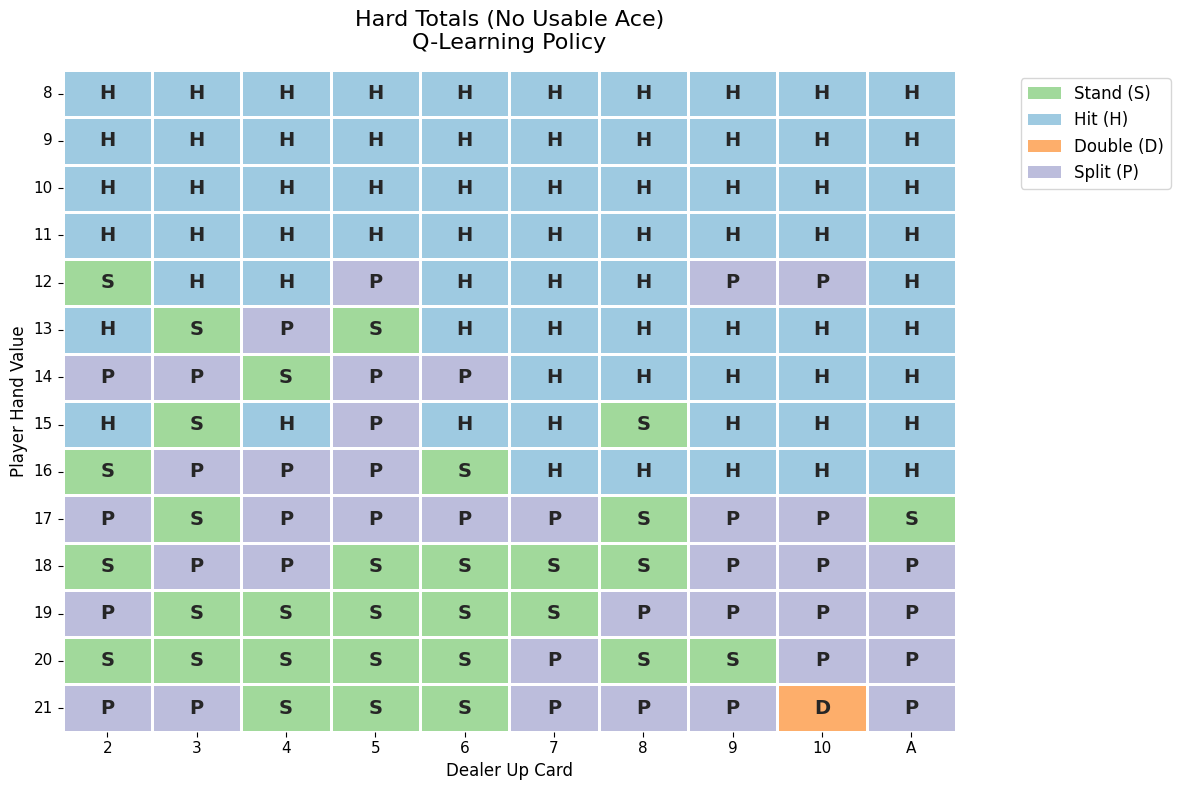

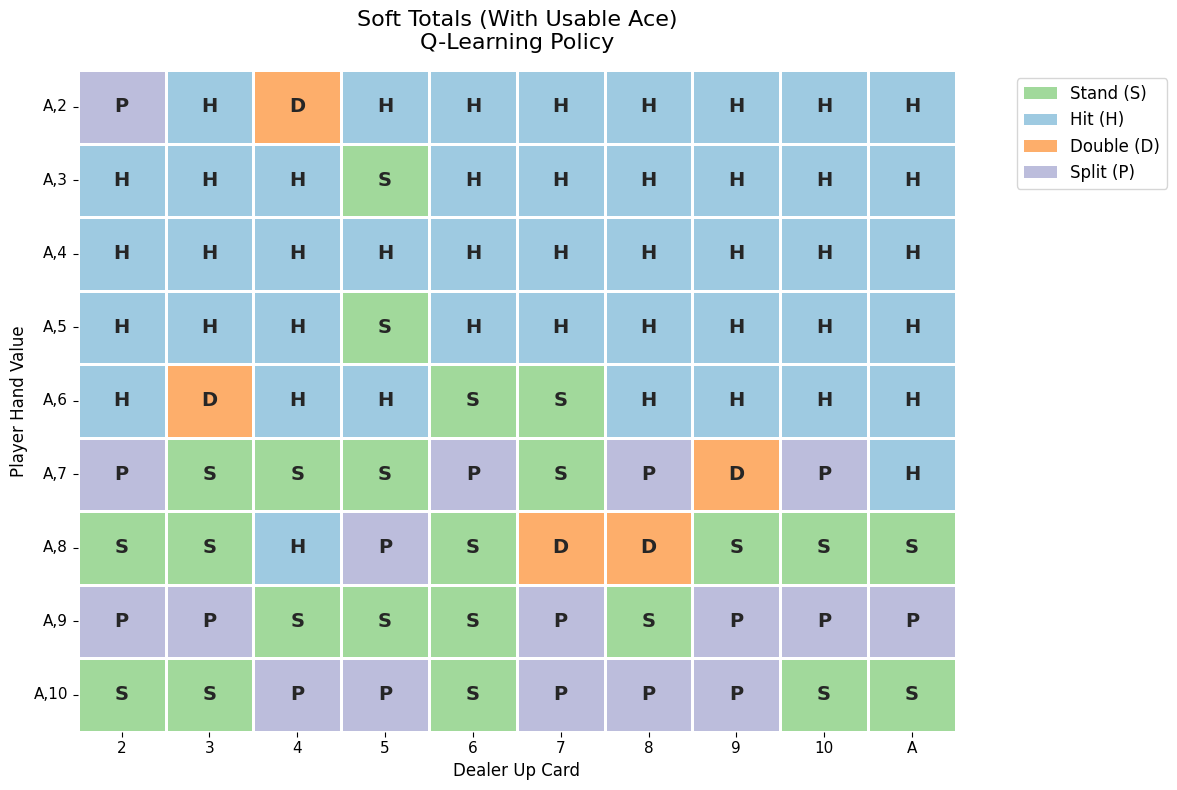

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from blackjack_env import Action

def create_strategy_heatmap(policy_Q_table, usable_ace_filter, title, algo_name):
    """
    Creates and displays a heatmap visualization of the basic strategy
    
    Args:
        policy_Q_table (defaultdict): The Q-table from training
        usable_ace_filter (int): 0 for hard totals, 1 for soft totals
        title (str): Title for the heatmap
        algo_name (str): Algorithm name for subtitle
    """
    # Player sums
    if usable_ace_filter == 0:  # Hard Totals
        player_sums = list(range(8, 22))
        row_labels = [str(s) for s in player_sums]
    else:  # Soft Totals
        player_sums = list(range(13, 22))
        row_labels = [f"A,{s-11}" if s != 21 else "A,10" for s in player_sums]

    dealer_cards = list(range(2, 12))
    col_labels = [str(d) if d != 11 else "A" for d in dealer_cards]
    
    # Initialize data arrays
    action_data = np.empty((len(player_sums), len(dealer_cards)), dtype=str)
    color_data = np.zeros((len(player_sums), len(dealer_cards)))
    
    # Pastel color palette (green, blue, orange, purple)
    action_colors = {
        "S": 0,  # Stand - Light Green
        "H": 1,  # Hit - Light Blue
        "D": 2,  # Double - Light Orange
        "P": 3   # Split - Light Purple
    }
    
    for i, p_sum in enumerate(player_sums):
        for j, d_card in enumerate(dealer_cards):
            state = (p_sum, d_card, usable_ace_filter)
            q_values = policy_Q_table[state]
            
            # Get optimal action
            actions_to_consider = [Action.STAND.value, Action.HIT.value, 
                                  Action.DOUBLE.value, Action.SPLIT.value]
            filtered_q_values = [q_values[a] for a in actions_to_consider]
            optimal_action_idx = np.argmax(filtered_q_values)
            optimal_action = actions_to_consider[optimal_action_idx]
            
            # Map to action character
            action_char = "S" if optimal_action == Action.STAND.value else \
                          "H" if optimal_action == Action.HIT.value else \
                          "D" if optimal_action == Action.DOUBLE.value else "P"
            
            action_data[i, j] = action_char
            color_data[i, j] = action_colors[action_char]
    
    # Create pastel colormap
    cmap = ListedColormap(['#a1d99b', '#9ecae1', '#fdae6b', '#bcbddc'])  # Green, Blue, Orange, Purple
    
    # Create plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(color_data, cmap=cmap, annot=action_data, fmt="", 
                cbar=False, linewidths=1, linecolor="white", 
                annot_kws={"size": 14, "weight": "bold"})
    
    plt.title(f"{title}\n{algo_name} Policy", fontsize=16, pad=15)
    plt.xlabel("Dealer Up Card", fontsize=12)
    plt.ylabel("Player Hand Value", fontsize=12)
    
    # Set custom ticks
    plt.xticks(np.arange(len(col_labels)) + 0.5, col_labels, fontsize=11)
    plt.yticks(np.arange(len(row_labels)) + 0.5, row_labels, fontsize=11, rotation=0)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#a1d99b', label='Stand (S)'),
        Patch(facecolor='#9ecae1', label='Hit (H)'),
        Patch(facecolor='#fdae6b', label='Double (D)'),
        Patch(facecolor='#bcbddc', label='Split (P)'),
    ]
    plt.legend(handles=legend_elements, loc='upper right', 
               bbox_to_anchor=(1.25, 1), fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- Generate Strategy Visualizations ---
print("\n### BASIC STRATEGY HEATMAPS ###")

# Extract Q-tables from training results
basic_mc_q = trained_policies["Basic_MC"]
basic_ql_q = trained_policies["Basic_QL"]

# Monte Carlo Policy
create_strategy_heatmap(basic_mc_q, 0, "Hard Totals (No Usable Ace)", "Monte Carlo")
create_strategy_heatmap(basic_mc_q, 1, "Soft Totals (With Usable Ace)", "Monte Carlo")

# Q-Learning Policy
create_strategy_heatmap(basic_ql_q, 0, "Hard Totals (No Usable Ace)", "Q-Learning")
create_strategy_heatmap(basic_ql_q, 1, "Soft Totals (With Usable Ace)", "Q-Learning")


--- Section 2: Evaluation and Comparison ---

--- Evaluating Policies for Basic Strategy Environment ---
Evaluating Monte Carlo Control for Basic...


100%|████████████████████████████████| 500000/500000 [00:27<00:00, 18209.76it/s]


  MC Results for Basic:
    Avg Reward: -0.0459
    Win Rate: 42.29%
    Loss Rate: 50.03%
    Push Rate: 7.68%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.58%


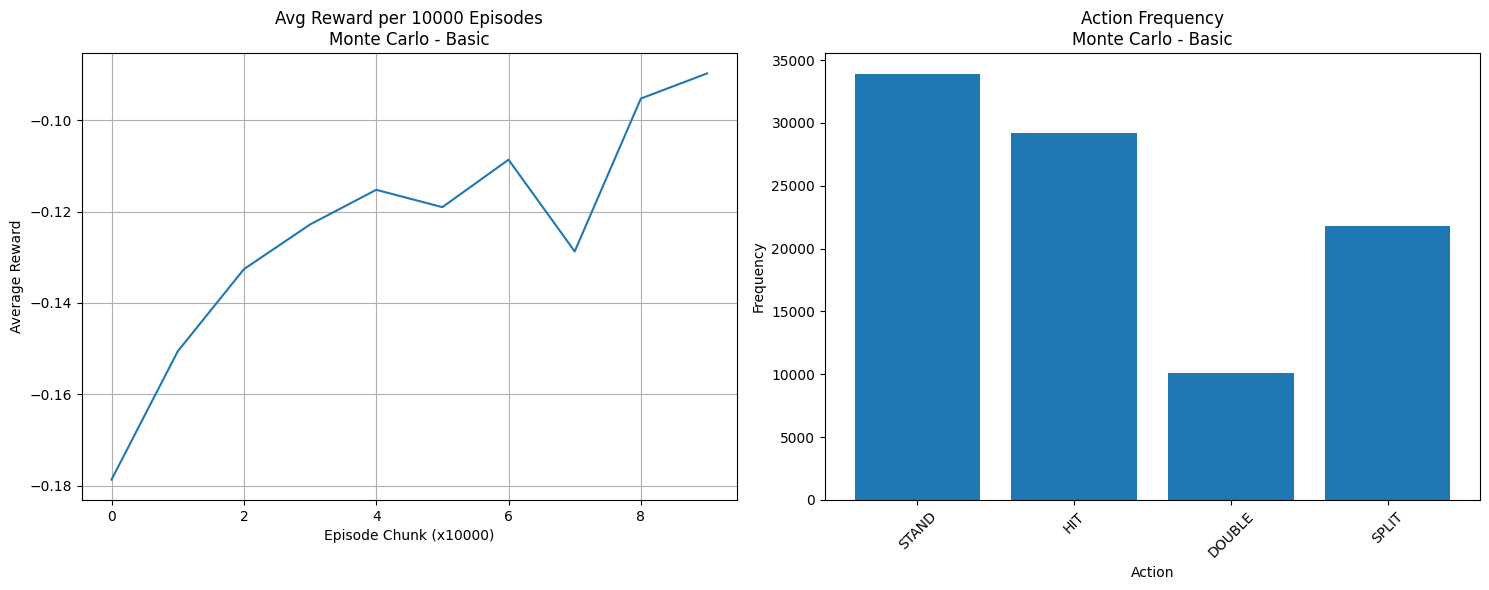

Evaluating Q-Learning for Basic...


100%|████████████████████████████████| 500000/500000 [00:27<00:00, 18082.72it/s]


  QL Results for Basic:
    Avg Reward: -0.0447
    Win Rate: 42.36%
    Loss Rate: 49.08%
    Push Rate: 8.56%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.55%


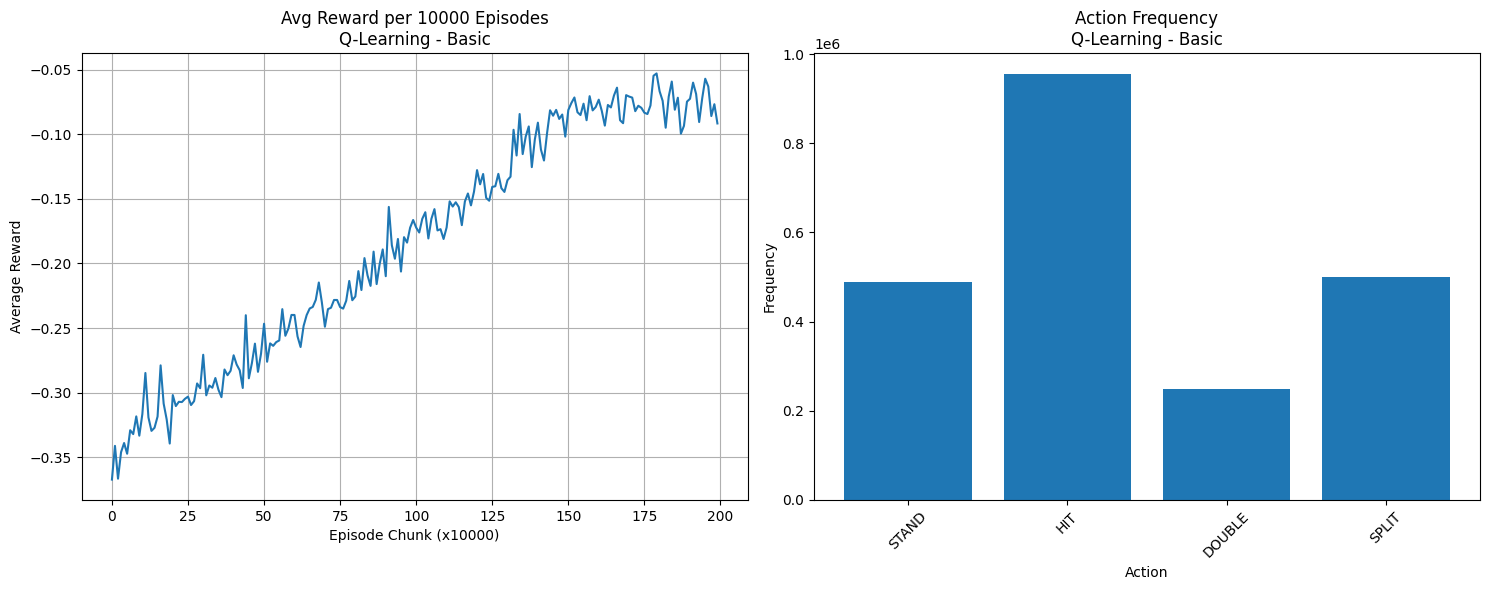

Evaluating Double Q-Learning for Basic (Enhanced Profit)...


100%|████████████████████████████████| 500000/500000 [00:27<00:00, 17970.83it/s]


  DQL Results for Basic (Enhanced Profit):
    Avg Reward: -0.0256
    Win Rate: 42.75%
    Loss Rate: 48.66%
    Push Rate: 8.59%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.50%


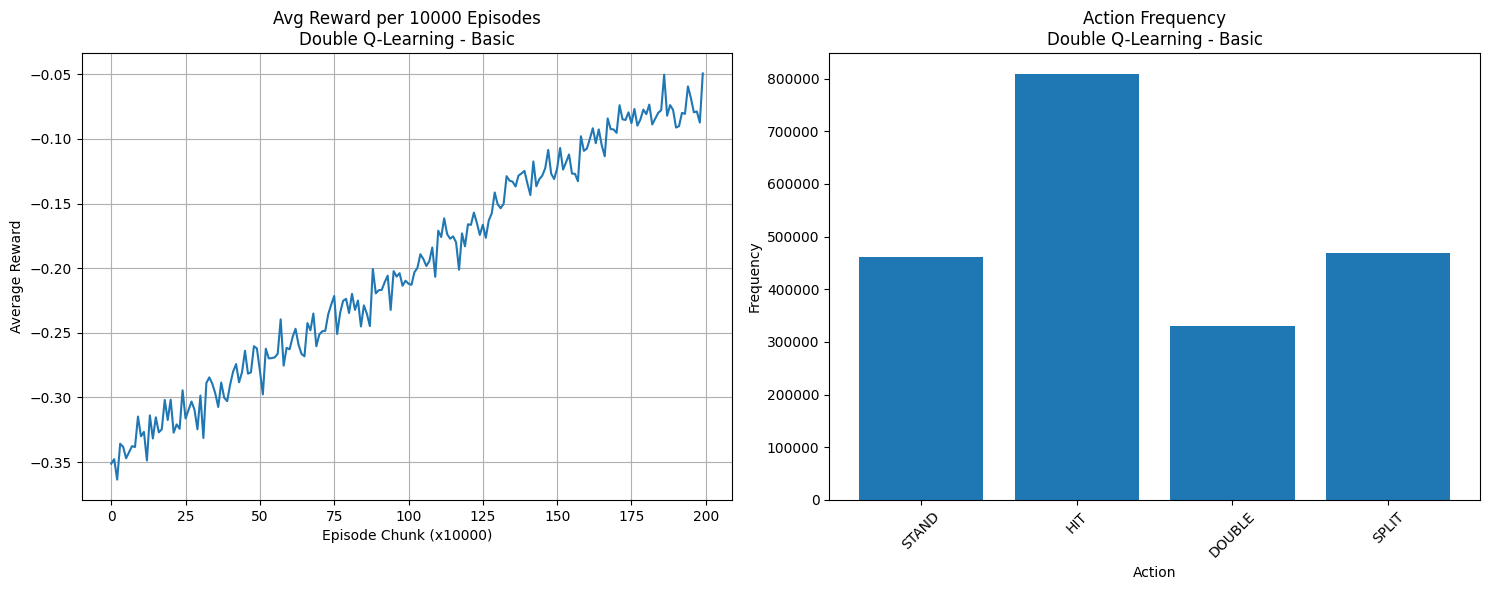


--- Evaluating Policies for Card Counting Environment ---
Evaluating Monte Carlo Control for Card Counting...


100%|████████████████████████████████| 500000/500000 [00:28<00:00, 17820.63it/s]


  MC Results for Card Counting:
    Avg Reward: -0.0324
    Win Rate: 42.91%
    Loss Rate: 48.61%
    Push Rate: 8.49%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.49%


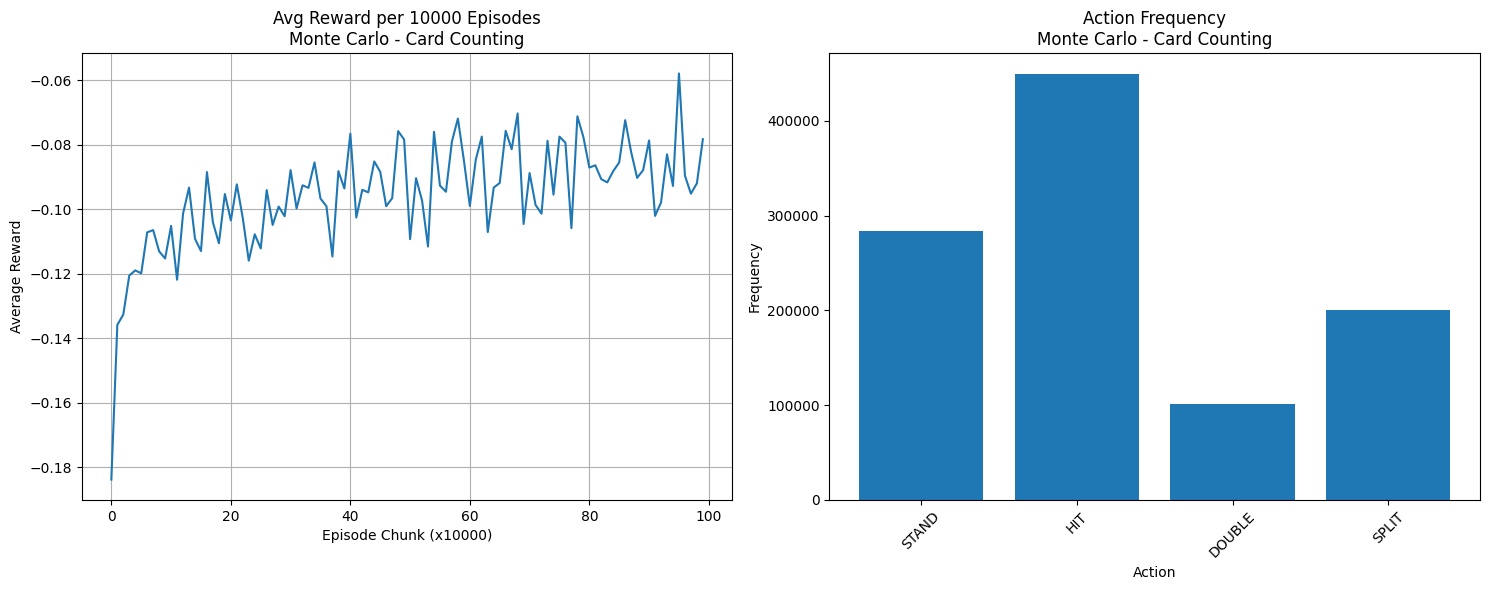

Evaluating Q-Learning for Card Counting...


100%|████████████████████████████████| 500000/500000 [00:28<00:00, 17658.10it/s]


  QL Results for Card Counting:
    Avg Reward: -0.0440
    Win Rate: 42.79%
    Loss Rate: 48.99%
    Push Rate: 8.22%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.49%


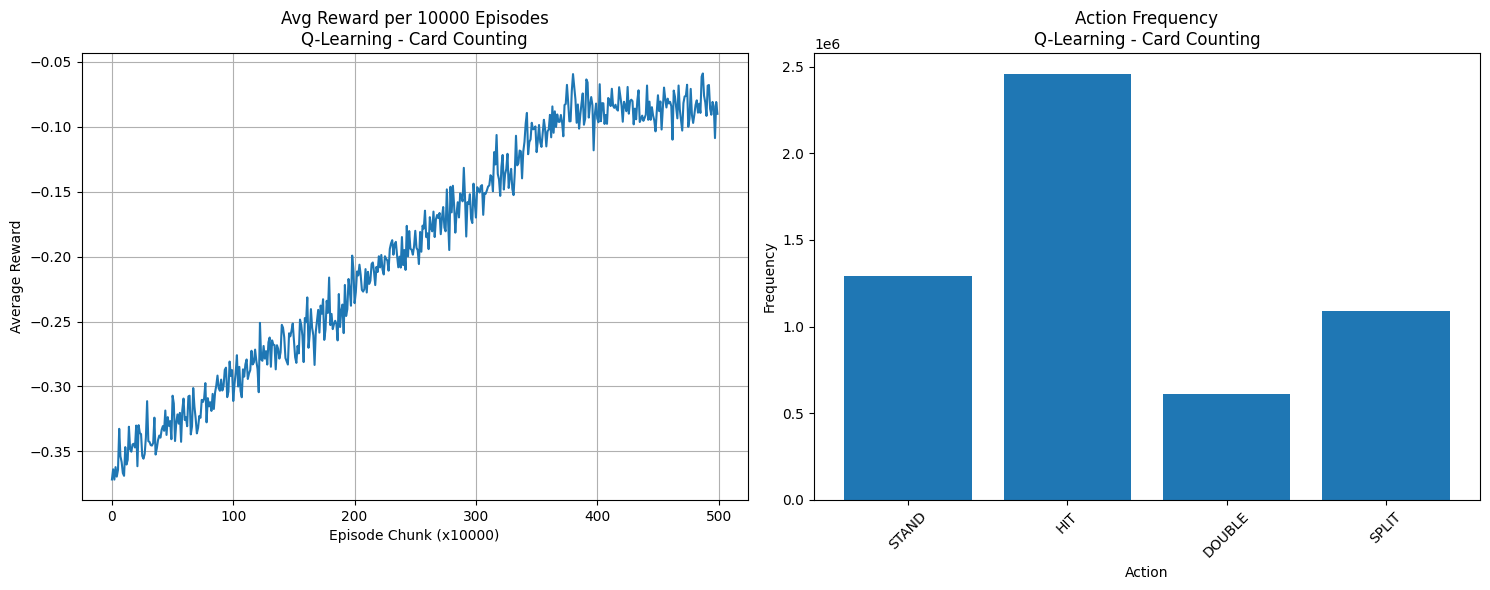

Evaluating Double Q-Learning for Card Counting (Enhanced Profit)...


100%|████████████████████████████████| 500000/500000 [00:28<00:00, 17475.07it/s]


  DQL Results for Card Counting (Enhanced Profit):
    Avg Reward: -0.0304
    Win Rate: 42.97%
    Loss Rate: 48.21%
    Push Rate: 8.82%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.54%


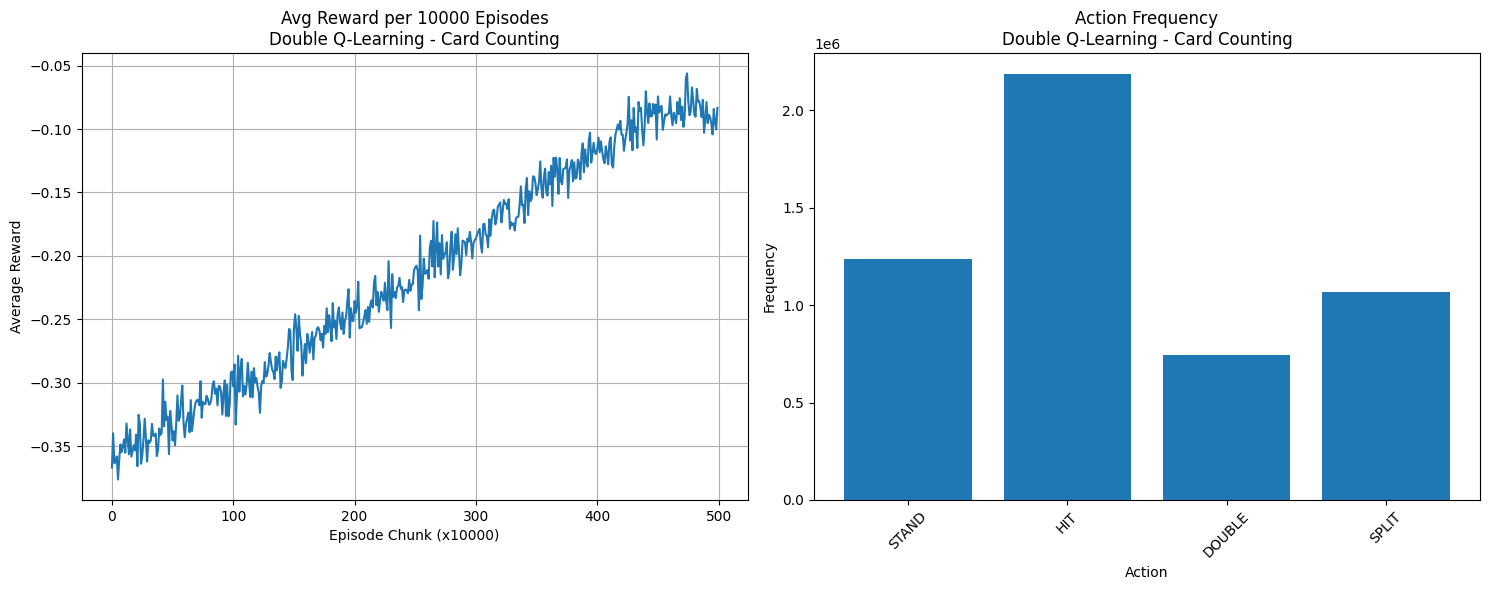


--- Evaluating Policies for Late Surrender Environment ---
Evaluating Monte Carlo Control for Late Surrender...


100%|████████████████████████████████| 500000/500000 [00:27<00:00, 18352.50it/s]


  MC Results for Late Surrender:
    Avg Reward: -0.0524
    Win Rate: 38.85%
    Loss Rate: 54.32%
    Push Rate: 6.82%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.54%


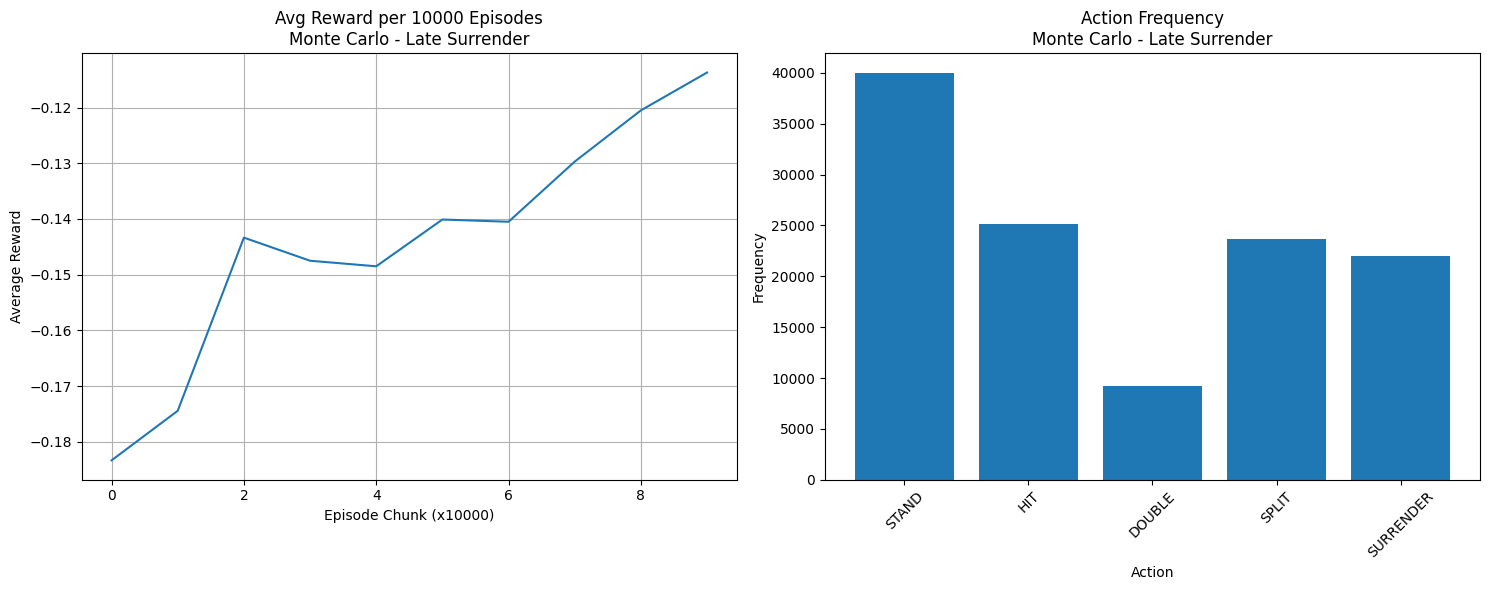


--- Evaluating Policies for Player 21 Wins Environment ---
Evaluating Monte Carlo Control for Player 21 Wins...


100%|████████████████████████████████| 500000/500000 [00:27<00:00, 18203.60it/s]


  MC Results for Player 21 Wins:
    Avg Reward: -0.0475
    Win Rate: 42.49%
    Loss Rate: 50.40%
    Push Rate: 7.11%
    Surrender Rate: 0.00%
    Natural Blackjack Rate: 4.54%


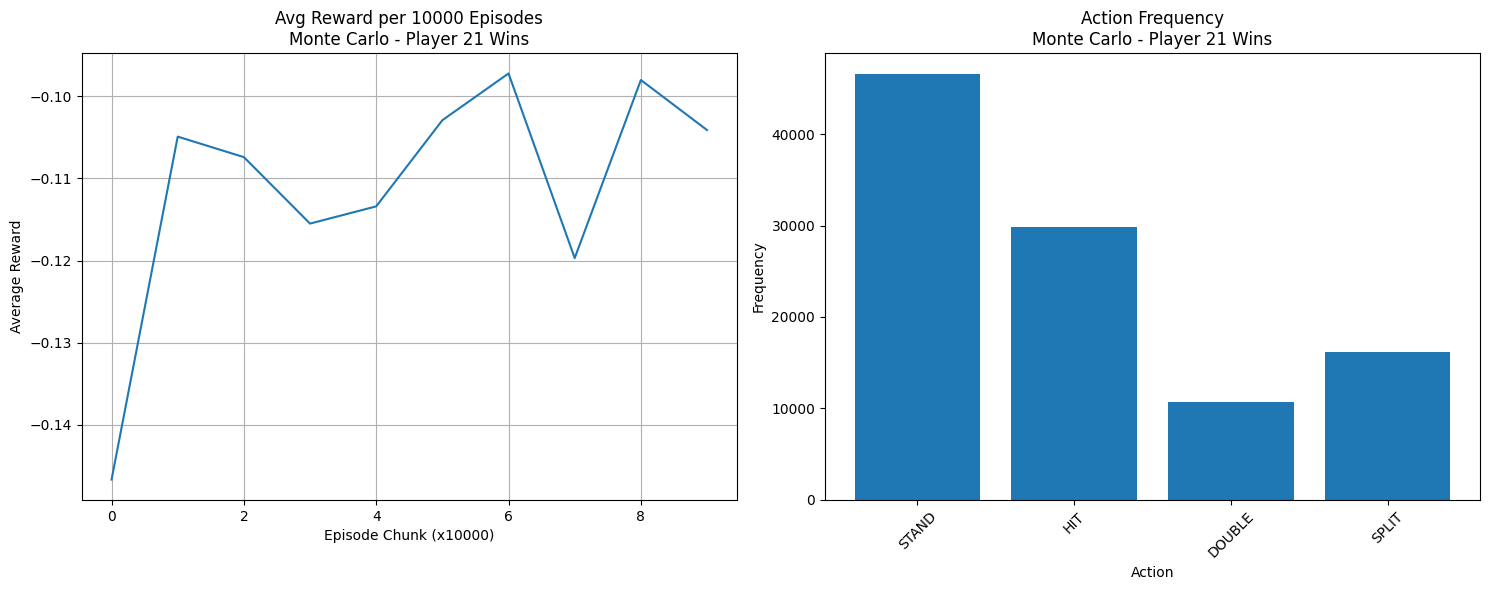


=== Overall Comparison ===

--- Win Rate Comparison ---
Environment          | Algorithm       | Win Rate        | Avg Reward     
---------------------------------------------------------------------------
Basic                | Monte Carlo     | 42.29%          | -0.0459
                     | Q-Learning      | 42.36%          | -0.0447
                     | Double Q-Learning | 42.75%          | -0.0256
Card Counting        | Monte Carlo     | 42.91%          | -0.0324
                     | Q-Learning      | 42.79%          | -0.0440
                     | Double Q-Learning | 42.97%          | -0.0304
Late Surrender       | Monte Carlo     | 38.85%          | -0.0524
Player 21 Wins       | Monte Carlo     | 42.49%          | -0.0475


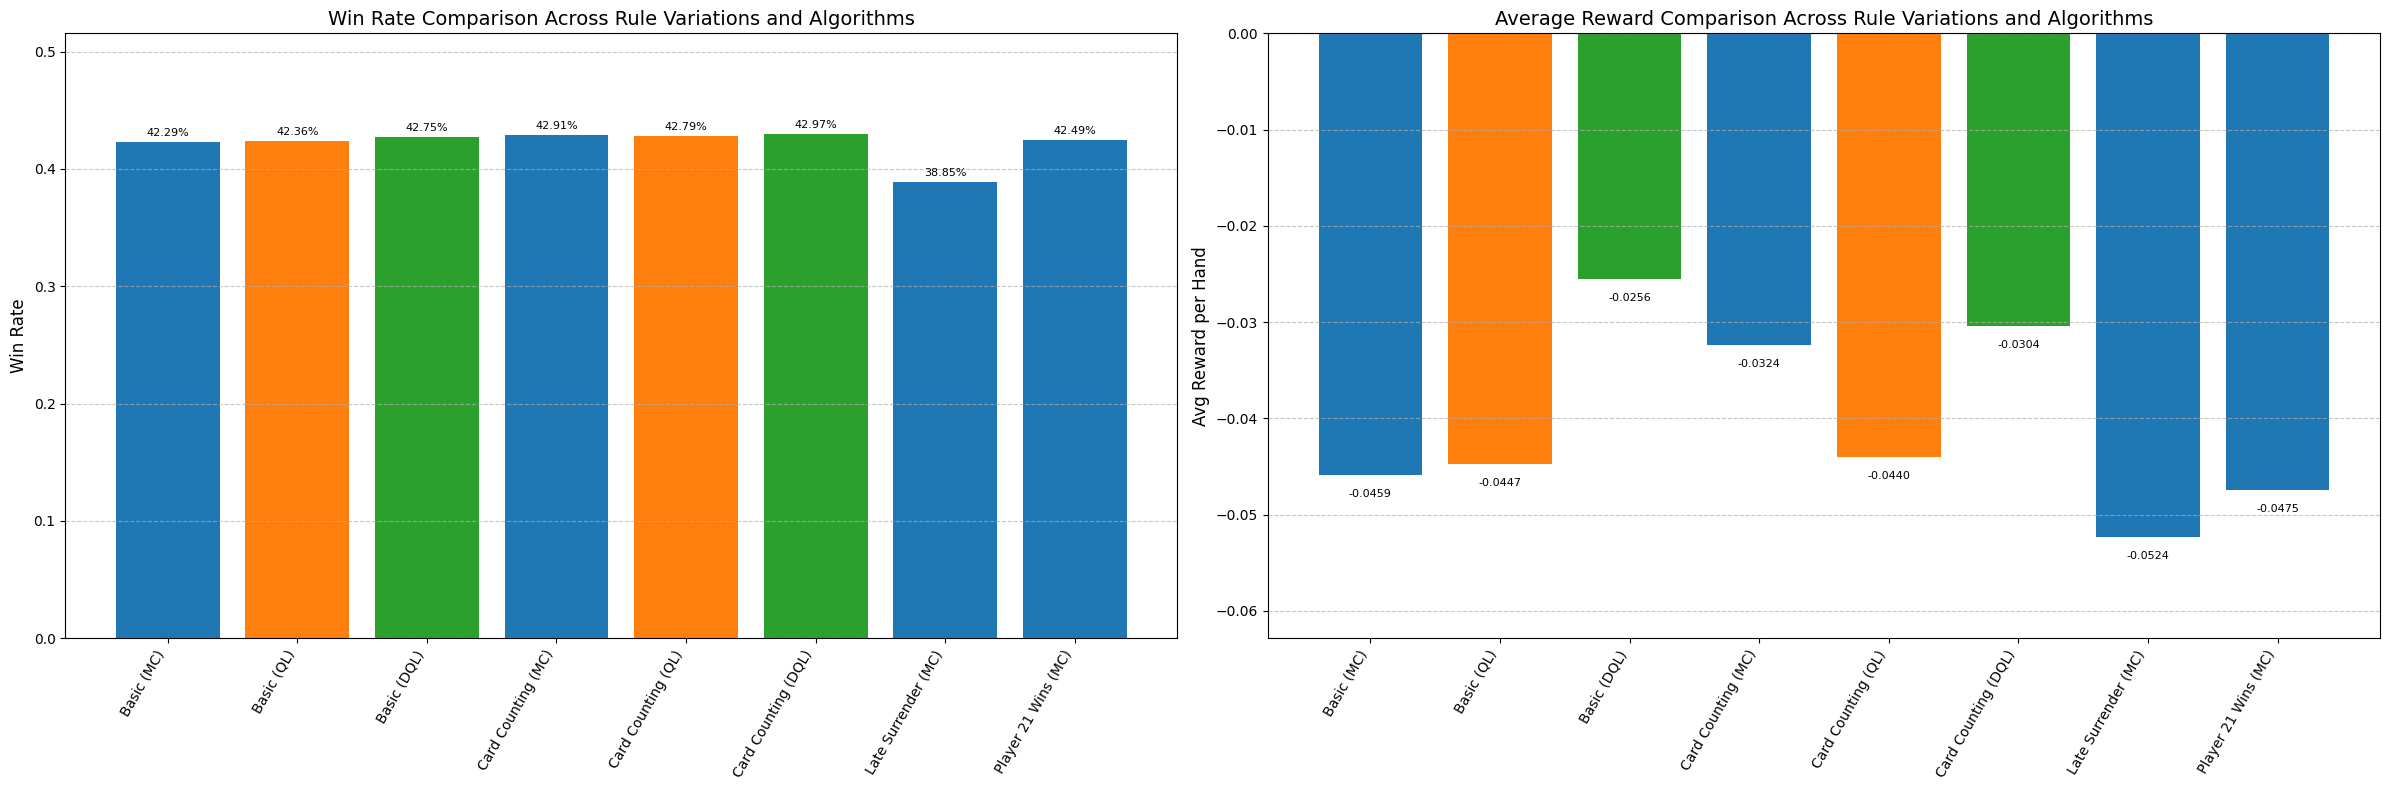

In [14]:
# --- Section 2: Evaluation and Comparison ---
print("\n--- Section 2: Evaluation and Comparison ---")

results = {}

# Define training metrics plotting function
def plot_training_metrics(episode_rewards, action_counts, algo_name, env_name):
    import matplotlib.pyplot as plt
    import numpy as np

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Average Reward per Episode Chunk
    avg_rewards = []
    for i in range(0, len(episode_rewards), 10000):
        chunk = episode_rewards[i:i+10000]
        avg_rewards.append(np.mean(chunk) if len(chunk) > 0 else 0)

    ax1.plot(avg_rewards)
    ax1.set_title(f'Avg Reward per 10000 Episodes\n{algo_name} - {env_name}')
    ax1.set_xlabel('Episode Chunk (x10000)')
    ax1.set_ylabel('Average Reward')
    ax1.grid(True)

    # Plot 2: Action Frequency Histogram
    # Only include SURRENDER for Late Surrender environment
    if "Late Surrender" in env_name:
        actions = ["STAND", "HIT", "DOUBLE", "SPLIT", "SURRENDER"]
        counts = action_counts
    else:
        actions = ["STAND", "HIT", "DOUBLE", "SPLIT"]
        counts = action_counts[:4]  # Only take first 4 action counts
    
    ax2.bar(actions, counts)
    ax2.set_title(f'Action Frequency\n{algo_name} - {env_name}')
    ax2.set_xlabel('Action')
    ax2.set_ylabel('Frequency')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Evaluate Basic Strategy
print("\n--- Evaluating Policies for Basic Strategy Environment ---")
print("Evaluating Monte Carlo Control for Basic...")
results["Basic_MC"]= evaluate_policy(basic_env, trained_policies["Basic_MC"])
print("  MC Results for Basic:")
for key, value in results["Basic_MC"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Basic MC
plot_training_metrics(
    trained_info["Basic_MC"]["rewards"],
    trained_info["Basic_MC"]["actions"],
    "Monte Carlo",
    "Basic"
)

print("Evaluating Q-Learning for Basic...")
results["Basic_QL"] = evaluate_policy(basic_env, trained_policies["Basic_QL"])
print("  QL Results for Basic:")
for key, value in results["Basic_QL"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Basic QL
plot_training_metrics(
    trained_info["Basic_QL"]["rewards"],
    trained_info["Basic_QL"]["actions"],
    "Q-Learning",
    "Basic"
)

print("Evaluating Double Q-Learning for Basic (Enhanced Profit)...")
results["Basic_DQL"] = evaluate_policy(basic_env, trained_policies["Basic_DQL"])
print("  DQL Results for Basic (Enhanced Profit):")
for key, value in results["Basic_DQL"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Basic DQL
plot_training_metrics(
    trained_info["Basic_DQL"]["rewards"],
    trained_info["Basic_DQL"]["actions"],
    "Double Q-Learning",
    "Basic"
)

# Evaluate Card Counting
print("\n--- Evaluating Policies for Card Counting Environment ---")
print("Evaluating Monte Carlo Control for Card Counting...")
results["Card Counting_MC"] = evaluate_policy(counting_env, trained_policies["Card Counting_MC"])
print("  MC Results for Card Counting:")
for key, value in results["Card Counting_MC"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Card Counting MC
plot_training_metrics(
    trained_info["Card Counting_MC"]["rewards"],
    trained_info["Card Counting_MC"]["actions"],
    "Monte Carlo",
    "Card Counting"
)

print("Evaluating Q-Learning for Card Counting...")
results["Card Counting_QL"] = evaluate_policy(counting_env, trained_policies["Card Counting_QL"])
print("  QL Results for Card Counting:")
for key, value in results["Card Counting_QL"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Card Counting QL
plot_training_metrics(
    trained_info["Card Counting_QL"]["rewards"],
    trained_info["Card Counting_QL"]["actions"],
    "Q-Learning",
    "Card Counting"
)

print("Evaluating Double Q-Learning for Card Counting (Enhanced Profit)...")
results["Card Counting_DQL"] = evaluate_policy(counting_env, trained_policies["Card Counting_DQL"])
print("  DQL Results for Card Counting (Enhanced Profit):")
for key, value in results["Card Counting_DQL"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Card Counting DQL
plot_training_metrics(
    trained_info["Card Counting_DQL"]["rewards"],
    trained_info["Card Counting_DQL"]["actions"],
    "Double Q-Learning",
    "Card Counting"
)

# Evaluate Late Surrender
print("\n--- Evaluating Policies for Late Surrender Environment ---")
print("Evaluating Monte Carlo Control for Late Surrender...")
results["Late Surrender_MC"] = evaluate_policy(surrender_env, trained_policies["Late Surrender_MC"])
print("  MC Results for Late Surrender:")
for key, value in results["Late Surrender_MC"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Late Surrender MC
plot_training_metrics(
    trained_info["Late Surrender_MC"]["rewards"],
    trained_info["Late Surrender_MC"]["actions"],
    "Monte Carlo",
    "Late Surrender"
)

# Evaluate Player 21 Wins
print("\n--- Evaluating Policies for Player 21 Wins Environment ---")
print("Evaluating Monte Carlo Control for Player 21 Wins...")
results["Player 21 Wins_MC"] = evaluate_policy(player21_env, trained_policies["Player 21 Wins_MC"])
print("  MC Results for Player 21 Wins:")
for key, value in results["Player 21 Wins_MC"].items():
    if "rate" in key: print(f"    {key.replace('_', ' ').title()}: {value:.2%}")
    else: print(f"    {key.replace('_', ' ').title()}: {value:.4f}")

# Plot training metrics for Player 21 Wins MC
plot_training_metrics(
    trained_info["Player 21 Wins_MC"]["rewards"],
    trained_info["Player 21 Wins_MC"]["actions"],
    "Monte Carlo",
    "Player 21 Wins"
)

# --- Overall Summary and Comparison Tables ---
print("\n=== Overall Comparison ===")

print("\n--- Win Rate Comparison ---")
print(f"{'Environment':<20} | {'Algorithm':<15} | {'Win Rate':<15} | {'Avg Reward':<15}")
print("-" * 75)

# Basic Strategy
print(f"{'Basic':<20} | {'Monte Carlo':<15} | {results['Basic_MC']['win_rate']:.2%}{'':<9} | {results['Basic_MC']['avg_reward']:.4f}")
print(f"{'':<20} | {'Q-Learning':<15} | {results['Basic_QL']['win_rate']:.2%}{'':<9} | {results['Basic_QL']['avg_reward']:.4f}")
print(f"{'':<20} | {'Double Q-Learning':<15} | {results['Basic_DQL']['win_rate']:.2%}{'':<9} | {results['Basic_DQL']['avg_reward']:.4f}")

# Card Counting
print(f"{'Card Counting':<20} | {'Monte Carlo':<15} | {results['Card Counting_MC']['win_rate']:.2%}{'':<9} | {results['Card Counting_MC']['avg_reward']:.4f}")
print(f"{'':<20} | {'Q-Learning':<15} | {results['Card Counting_QL']['win_rate']:.2%}{'':<9} | {results['Card Counting_QL']['avg_reward']:.4f}")
print(f"{'':<20} | {'Double Q-Learning':<15} | {results['Card Counting_DQL']['win_rate']:.2%}{'':<9} | {results['Card Counting_DQL']['avg_reward']:.4f}")

# Late Surrender
print(f"{'Late Surrender':<20} | {'Monte Carlo':<15} | {results['Late Surrender_MC']['win_rate']:.2%}{'':<9} | {results['Late Surrender_MC']['avg_reward']:.4f}")

# Player 21 Wins
print(f"{'Player 21 Wins':<20} | {'Monte Carlo':<15} | {results['Player 21 Wins_MC']['win_rate']:.2%}{'':<9} | {results['Player 21 Wins_MC']['avg_reward']:.4f}")

# --- Visualization of Results ---
# Prepare data for plotting based on the specific trained algorithms
plot_data = []

# Basic Strategy
plot_data.append({"env": "Basic", "algo": "MC", "win_rate": results["Basic_MC"]["win_rate"], "avg_reward": results["Basic_MC"]["avg_reward"]})
plot_data.append({"env": "Basic", "algo": "QL", "win_rate": results["Basic_QL"]["win_rate"], "avg_reward": results["Basic_QL"]["avg_reward"]})
plot_data.append({"env": "Basic", "algo": "DQL", "win_rate": results["Basic_DQL"]["win_rate"], "avg_reward": results["Basic_DQL"]["avg_reward"]})

# Card Counting
plot_data.append({"env": "Card Counting", "algo": "MC", "win_rate": results["Card Counting_MC"]["win_rate"], "avg_reward": results["Card Counting_MC"]["avg_reward"]})
plot_data.append({"env": "Card Counting", "algo": "QL", "win_rate": results["Card Counting_QL"]["win_rate"], "avg_reward": results["Card Counting_QL"]["avg_reward"]})
plot_data.append({"env": "Card Counting", "algo": "DQL", "win_rate": results["Card Counting_DQL"]["win_rate"], "avg_reward": results["Card Counting_DQL"]["avg_reward"]})

# Late Surrender
plot_data.append({"env": "Late Surrender", "algo": "MC", "win_rate": results["Late Surrender_MC"]["win_rate"], "avg_reward": results["Late Surrender_MC"]["avg_reward"]})

# Player 21 Wins
plot_data.append({"env": "Player 21 Wins", "algo": "MC", "win_rate": results["Player 21 Wins_MC"]["win_rate"], "avg_reward": results["Player 21 Wins_MC"]["avg_reward"]})


# Extract data for plotting
envs_in_plot = [d["env"] for d in plot_data]
algos_in_plot = [d["algo"] for d in plot_data]
win_rates_in_plot = [d["win_rate"] for d in plot_data]
avg_rewards_in_plot = [d["avg_reward"] for d in plot_data]

# Create unique labels for x-axis
unique_env_algo_labels = [f"{e} ({a})" for e, a in zip(envs_in_plot, algos_in_plot)]

x_pos = np.arange(len(unique_env_algo_labels))

fig, axes = plt.subplots(1, 2, figsize=(24, 8)) # Increased figure size

# Plot Win Rates
bars_win = axes[0].bar(x_pos, win_rates_in_plot, color=['#1f77b4' if algo == 'MC' else ('#ff7f0e' if algo == 'QL' else '#2ca02c') for algo in algos_in_plot])
axes[0].set_ylabel('Win Rate', fontsize=12)
axes[0].set_title('Win Rate Comparison Across Rule Variations and Algorithms', fontsize=14)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(unique_env_algo_labels, rotation=60, ha='right', fontsize=10)
axes[0].set_ylim(0, max(win_rates_in_plot) * 1.2)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add win rate percentages on top of bars
def autolabel_win(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel_win(bars_win, axes[0])

# Plot Average Rewards
bars_reward = axes[1].bar(x_pos, avg_rewards_in_plot, color=['#1f77b4' if algo == 'MC' else ('#ff7f0e' if algo == 'QL' else '#2ca02c') for algo in algos_in_plot])
axes[1].set_ylabel('Avg Reward per Hand', fontsize=12)
axes[1].set_title('Average Reward Comparison Across Rule Variations and Algorithms', fontsize=14)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(unique_env_algo_labels, rotation=60, ha='right', fontsize=10)

min_reward_plot = min(0, min(avg_rewards_in_plot) * 1.2)
max_reward_plot = max(0, max(avg_rewards_in_plot) * 1.2)
axes[1].set_ylim(min_reward_plot, max_reward_plot)

axes[1].axhline(0, color='grey', linewidth=0.8, linestyle='--')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add average reward values on top of bars
def autolabel_reward(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -10),  # Adjust offset for negative values
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)

autolabel_reward(bars_reward, axes[1])

plt.tight_layout()
plt.show()

Successfully loaded training stats from trained_blackjack_policies/training_stats.pkl


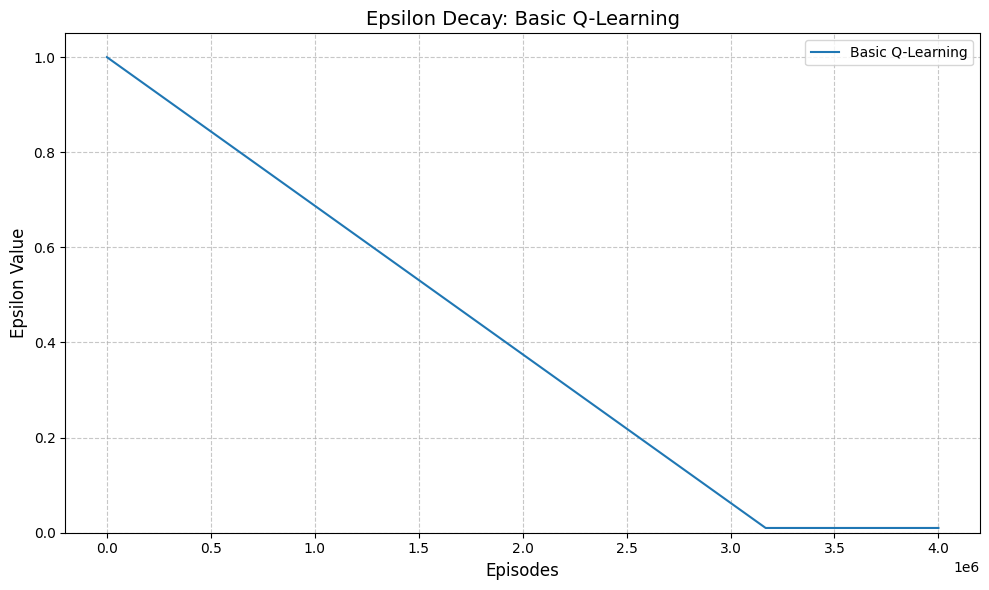

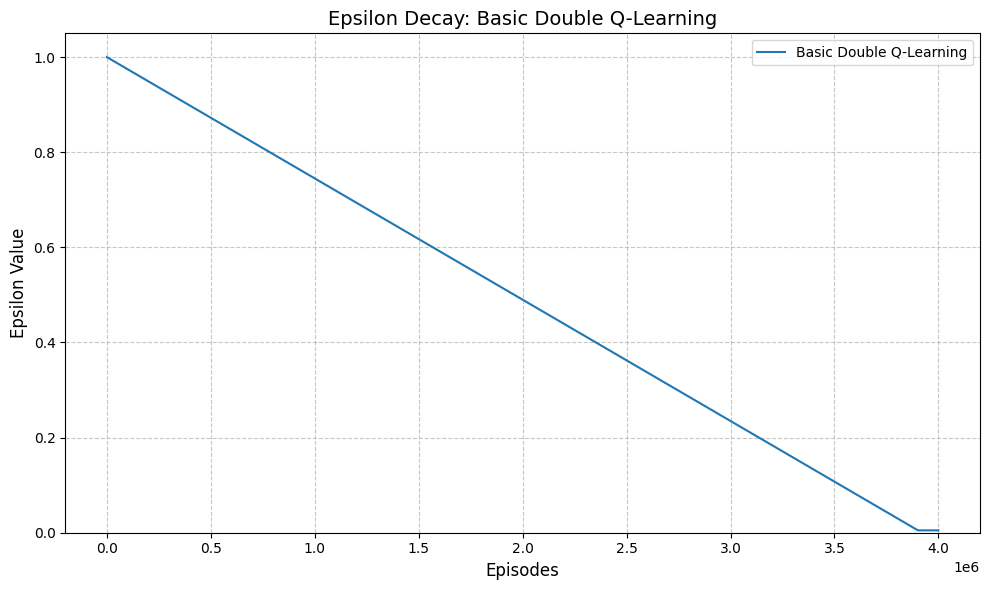

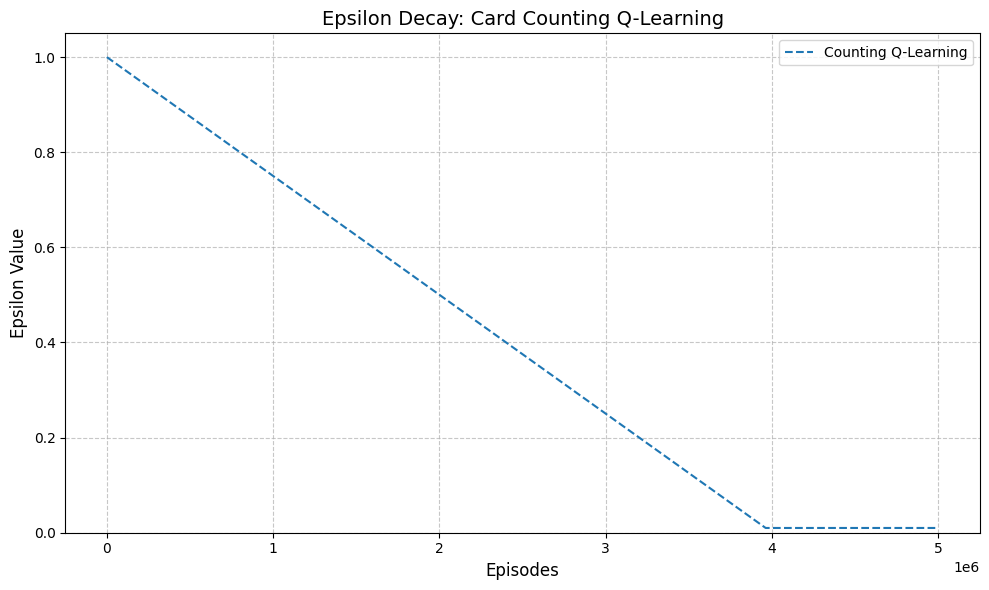

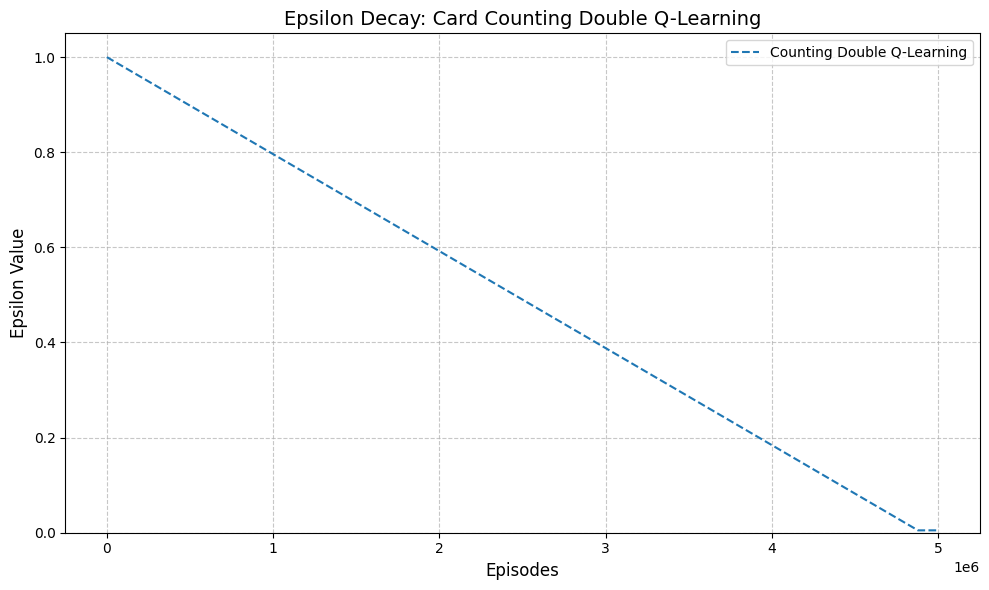

In [12]:
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns # For better aesthetics, if you like

# --- Configuration ---
policies_dir = "trained_blackjack_policies" # Directory where policies and stats are saved
stats_filename = os.path.join(policies_dir, "training_stats.pkl")

# --- Load Training Stats ---
training_stats = None
if os.path.exists(stats_filename):
    try:
        with open(stats_filename, 'rb') as f:
            training_stats = pickle.load(f)
        print(f"Successfully loaded training stats from {stats_filename}")
    except Exception as e:
        print(f"Error loading training stats from {stats_filename}: {e}")
else:
    print(f"Error: Training stats file not found at {stats_filename}. Please ensure training was completed successfully.")

# --- Generate Separate Epsilon Decay Plots ---
if training_stats:
    plot_configs = [
        {"key": "Basic_QL", "title": "Epsilon Decay: Basic Q-Learning", "label": "Basic Q-Learning", "linestyle": '-'},
        {"key": "Basic_DQL", "title": "Epsilon Decay: Basic Double Q-Learning", "label": "Basic Double Q-Learning", "linestyle": '-'},
        {"key": "Card Counting_QL", "title": "Epsilon Decay: Card Counting Q-Learning", "label": "Counting Q-Learning", "linestyle": '--'},
        {"key": "Card Counting_DQL", "title": "Epsilon Decay: Card Counting Double Q-Learning", "label": "Counting Double Q-Learning", "linestyle": '--'}
    ]

    for config in plot_configs:
        key = config["key"]
        title = config["title"]
        label = config["label"]
        linestyle = config["linestyle"]

        if key in training_stats and "epsilon_history" in training_stats[key]:
            epsilon_history = training_stats[key]["epsilon_history"]
            if epsilon_history:
                plt.figure(figsize=(10, 6)) # Smaller figure size for individual plots
                plt.plot(epsilon_history, label=label, linestyle=linestyle)
                plt.title(title, fontsize=14)
                plt.xlabel('Episodes', fontsize=12)
                plt.ylabel('Epsilon Value', fontsize=12)
                plt.ylim(0, 1.05)
                plt.legend(fontsize=10)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Warning: {key} epsilon_history is empty, skipping plot.")
        else:
            print(f"Warning: Data for {key} not found in training_stats, skipping plot.")
else:
    print("Cannot generate plots: training_stats data is not available.")